### Import MNIST Data

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

# Write MNIST data locally, from request
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

# Load request data into memory as numpy arrays
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding="latin-1")

import torch

# Convert numpy arrays into tensors
x_train, y_train, x_val, y_val = map(
    torch.tensor, (x_train, y_train, x_val, y_val)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### Plot A Sample Image

torch.Size([50000, 784])


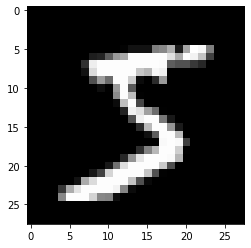

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

### OLD Models.py Code

In [4]:
from torch import nn
import torch.nn.functional as F

class Mnist_Logistic(nn.Module):

    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True) # Define a single, linear, layer

    def forward(self, xb):
        return self.lin(xb)

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

### Training Helper Functions

In [15]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F
import torch.nn as nn

# Calculate the loss for a single training batch
def calc_batch_loss(model, loss_func, xb, yb, opt=None):
    
    # Make predictions and get loss
    loss = loss_func(model(xb), yb)

    # Backpropagate if an optimizer is specified
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return loss and length
    return loss.item(), len(xb)

# Fit an arbitrary model
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            print(yb)
            calc_batch_loss(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[calc_batch_loss(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

# Returns DataLoader objects for fitting models, given training data, 
# validation data, and a training batch size
def get_dataloaders(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

# Helper function to create a pytorch model and optim (for doing gradient calculations)
def get_model_and_optimization(model = Mnist_Logistic()):
    return model, optim.SGD(model.parameters(), lr=lr)

# Lambda PyTorch Module that can be inserted into a "Sequential"
# object to perform arbitrary lambda operations on NN layers.
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

### MNIST Linear Model
This model is from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html#switch-to-cnn).

In [16]:
bs = 64 # BATCH SIZE
lr = 0.5 # LEARNING RATE
num_epochs = 2
loss_func = F.cross_entropy

print(x_train.shape)
print(y_train.shape)
train_dataset = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_val, y_val)

train_dl, valid_dl = get_dataloaders(train_dataset, valid_ds, bs)
model, opt = get_model_and_optimization()
fit(num_epochs, model, loss_func, opt, train_dl, valid_dl)

torch.Size([50000, 784])
torch.Size([50000])
tensor([0, 7, 3, 6, 9, 2, 4, 6, 5, 8, 9, 1, 3, 9, 5, 9, 3, 9, 4, 1, 4, 7, 7, 4,
        0, 4, 9, 4, 2, 1, 0, 0, 7, 1, 4, 2, 4, 4, 7, 2, 3, 0, 0, 3, 7, 3, 0, 8,
        6, 5, 4, 1, 1, 9, 1, 1, 5, 7, 1, 3, 4, 9, 1, 0])
tensor([9, 8, 7, 1, 4, 0, 0, 1, 9, 8, 4, 7, 4, 2, 4, 9, 8, 2, 0, 3, 6, 5, 4, 3,
        1, 8, 9, 3, 6, 2, 8, 0, 8, 5, 9, 7, 1, 8, 2, 0, 1, 9, 1, 0, 0, 7, 5, 3,
        1, 7, 3, 1, 9, 5, 1, 4, 1, 9, 1, 9, 5, 5, 4, 3])
tensor([9, 0, 3, 5, 3, 8, 4, 0, 8, 9, 5, 8, 9, 0, 0, 6, 1, 9, 0, 5, 3, 2, 5, 6,
        5, 3, 9, 7, 7, 0, 1, 7, 3, 7, 7, 0, 5, 6, 1, 1, 8, 9, 3, 5, 0, 1, 3, 3,
        1, 5, 4, 9, 1, 2, 8, 0, 6, 6, 0, 9, 3, 3, 8, 5])
tensor([5, 2, 4, 2, 4, 8, 9, 4, 6, 8, 3, 2, 5, 0, 5, 4, 4, 2, 8, 4, 9, 7, 9, 2,
        4, 9, 6, 4, 0, 9, 6, 0, 1, 5, 5, 9, 1, 1, 3, 9, 7, 5, 9, 1, 0, 6, 8, 7,
        7, 8, 3, 1, 3, 9, 9, 3, 3, 3, 6, 4, 4, 2, 7, 1])
tensor([9, 1, 0, 8, 4, 4, 8, 7, 3, 3, 1, 2, 2, 6, 0, 4, 4, 5, 7, 9, 9, 3, 6, 9,
       

### MNIST CNN

In [10]:
import Models

lr = 0.1

def preprocess_input(data):
    data = data.view(-1, 1, 28, 28)
    return data

model = nn.Sequential(
    Lambda(preprocess_input),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda X : X.view(X.size(0), -1)),
)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(num_epochs, model, loss_func, opt, train_dl, valid_dl)

RuntimeError: expected scalar type Double but found Float